In [124]:
import pandas as pd
import statsmodels.api as sm

import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
t = go.layout.Template(
    layout=go.Layout(
        hovermode='x'
    )
)
t.data.scatter = [
    go.Scatter(hoverlabel=go.scatter.Hoverlabel(namelength=-1))
]
pio.templates["my"] = t
pio.templates.default = "plotly_dark+my"

# House Prices Inflation

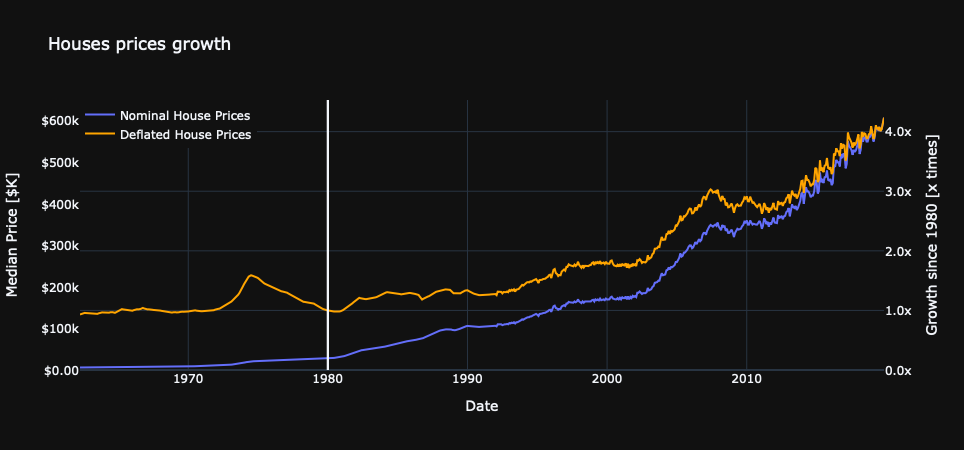

In [132]:
houses = pd.read_csv('out/gen/house-prices_1962-now.csv', parse_dates=True, index_col=0)

df = houses.copy()
k = houses.loc["1980-01-01", 'Deflated House Prices']
df['Deflated House Prices X'] = df['Deflated House Prices']/k
fig = go.Figure(
 data = [
     go.Scatter(x=df.index, y=df['Nominal House Prices'], 
                name="Nominal House Prices"),
     go.Scatter(x=df.index, y=df['Deflated House Prices'], 
                name="Deflated House Prices",  line=go.scatter.Line(color='Orange')),
     go.Scatter(x=df.index, y=df['Deflated House Prices X'], yaxis="y2", opacity=0, 
                name="Growth since 1980", showlegend=False, line=go.scatter.Line(color='Orange'))
 ],
 layout=go.Layout(
    title='Houses prices growth',
    
    yaxis=go.layout.YAxis(title="Median Price [$K]", tickformat="$.3s", range=[0,650000], showgrid=False),
    yaxis2=go.layout.YAxis(
        title='Growth since 1980 [x times]', overlaying='y', side='right',
        range=[0,650000/k], tickformat=".1f", ticksuffix='x'
    ),
    xaxis=go.layout.XAxis(title = "Date"),
    shapes = [dict(x0="1980-01-01", y0=0, y1=650000, x1="1980-01-01")],
    legend = go.layout.Legend(x=0)
))
fig.show()


Sources: REINZ, Stats NZ

Until around 1982 the houses were appreciated along with other products. 

However, sinse than houses appreciated 5x times more than other products.

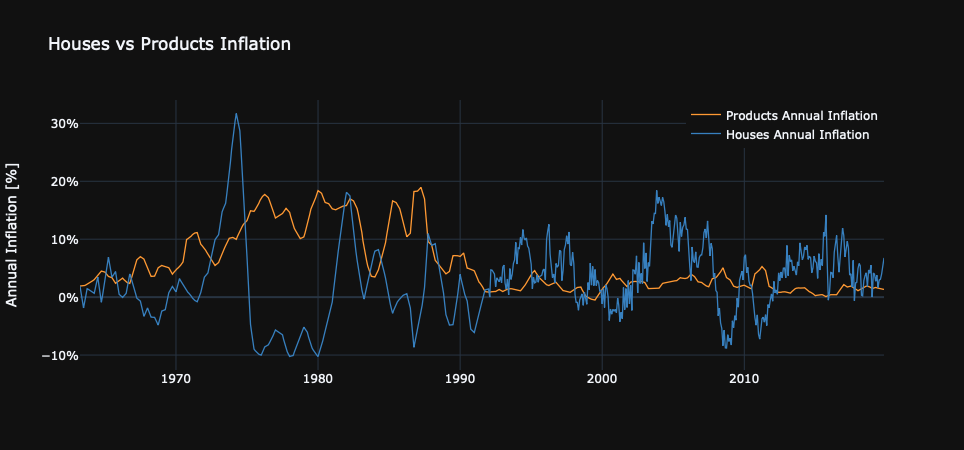

In [115]:
df = houses.pct_change(12).dropna()[['Deflator', 'Deflated House Prices']]
df.columns = ['Products Annual Inflation', 'Houses Annual Inflation']
df.iplot(
    layout=go.Layout(
        title = "Houses vs Products Inflation",
        yaxis=go.layout.YAxis(title='Annual Inflation [%]', tickformat='%'),
        legend = go.layout.Legend(xanchor="right", x=1)
    )
)

Sources: REINZ, Stats NZ

Except two periods following lange finance crysises, the housing annual inflation level was higher than consumable's inflation. Up to 20% in 2004 vs 2.5% at the same period.

# Rent

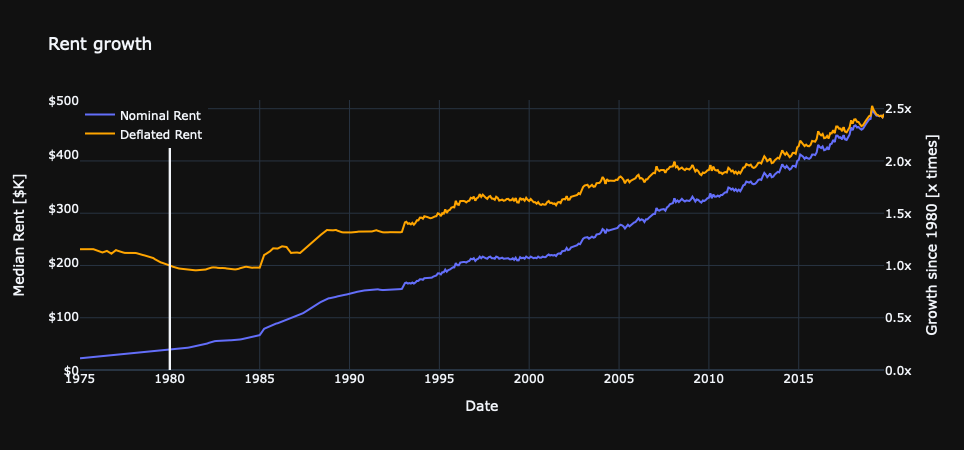

In [133]:
rent = pd.read_csv('out/gen/rent_1975-now.csv', parse_dates=True, index_col=0)

df = rent[['Nominal Rent', 'Deflated Rent']]

k = df.loc["1980-01-01", 'Deflated Rent']
df['Deflated Rent X'] = df['Deflated Rent']/k
fig = go.Figure(
 data = [
     go.Scatter(x=df.index, y=df['Nominal Rent'], 
                name="Nominal Rent"),
     go.Scatter(x=df.index, y=df['Deflated Rent'], 
                name="Deflated Rent",  line=go.scatter.Line(color='Orange')),
     go.Scatter(x=df.index, y=df['Deflated Rent X'], yaxis="y2", opacity=0, 
                name="Growth since 1980", line=go.scatter.Line(color='Orange'), showlegend=False)
 ],
 layout=go.Layout(
    title='Rent growth',
    yaxis=go.layout.YAxis(title="Median Rent [$K]", tickformat="$.0f", range=[0,500], showgrid=False),
    yaxis2=go.layout.YAxis(
        title='Growth since 1980 [x times]', overlaying='y', side='right',
        range=[0,500/k], tickformat=".1f", ticksuffix='x'
    ),
    xaxis=go.layout.XAxis(title = "Date"),
    shapes=[dict(x0="1980-01-01", y0=0, y1=500, x1="1980-01-01")],
    legend = go.layout.Legend(x=0)
))
fig.show()

Sources: MBIE NZ, Stats NZ

Rent growth twice higher than other products since 1975.

Possibly, it's due to income growth which will correlate with GDP per capita growth.

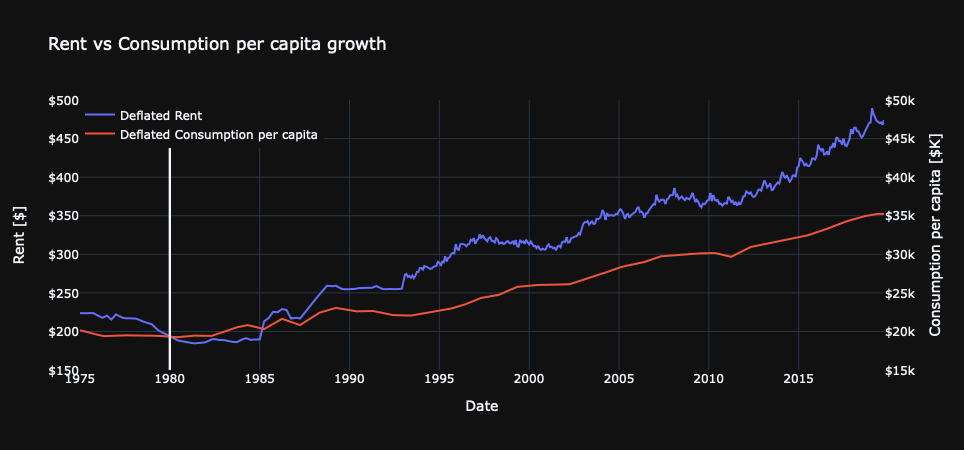

In [141]:
gdp = pd.read_csv('out/gen/gdp_1860-now.csv', parse_dates=True, index_col=0)

df = pd.merge_asof(rent, gdp.resample('MS').interpolate('linear'), left_index=True, right_index=True)

fig = go.Figure(
 data = [
     go.Scatter(x=df.index, y=df['Deflated Rent'], 
                name="Deflated Rent"),
     go.Scatter(x=df.index, y=df['Deflated Consumption per capita'], yaxis="y2", 
                name="Deflated Consumption per capita")
 ],
 layout=go.Layout(
    title='Rent vs Consumption per capita growth',
    yaxis=go.layout.YAxis(title="Rent [$]", tickformat="$.0f", range=[150,500]),
    yaxis2=go.layout.YAxis(
        title='Consumption per capita [$K]', overlaying='y', side='right',
        tickformat="$.2s", showgrid=False, range=[15000,50000]
    ),
    xaxis=go.layout.XAxis(title = "Date"),
    shapes=[dict(x0="1980-01-01", y0=150, y1=500, x1="1980-01-01")],
    legend = go.layout.Legend(x=0)
))
fig.show()

Sources: MBIE, Stats NZ, RBNZ

Rent was growing faster than other consumption. 

1. Remove rent from consumption
2. Hypotises: The higher price, the more people with higher income have to rent pushing the rent higher. It makes it more interesting to invest in houses. This is pushing the prices even higher.

# Dwellings

Optimization terminated successfully.
         Current function value: -5.919113
         Iterations: 47
         Function evaluations: 102


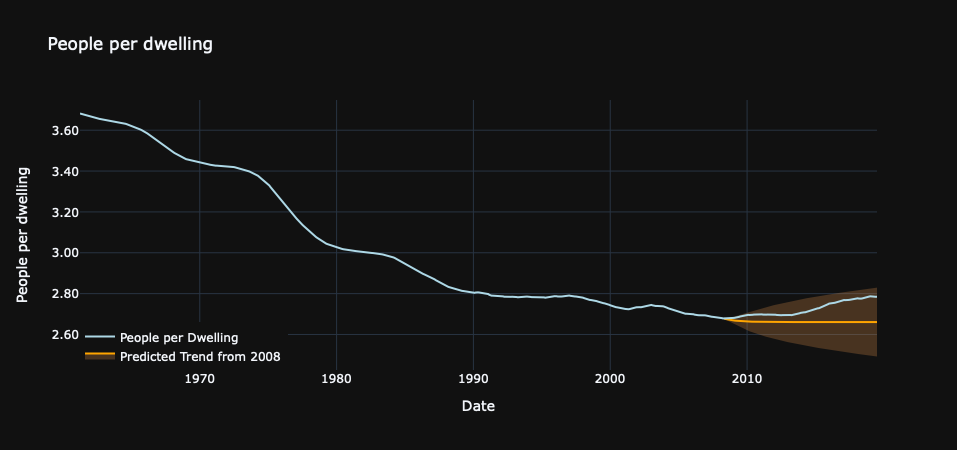

In [81]:
dwellings = pd.read_csv('out/gen/dwellings_stats-nz_1961-now.csv', parse_dates=True, index_col=0)
dwellings.index = pd.DatetimeIndex(dwellings.index.values, freq='MS')

df = dwellings.loc["1980-04-01":"2008-04-01", "People per Dwelling"]

model = sm.tsa.SARIMAX(df, order=(1, 1, 1))#, trend='c')
model_fit = model.fit(method='nm')

df = pd.merge_asof(dwellings, model_fit.get_forecast(dwellings.index.max()).summary_frame(), left_index=True, right_index=True)


fig = go.Figure(
 data = [
     go.Scatter(x=df.index, y=df['mean_ci_upper'], 
                showlegend=False, name="Minimum predicted", 
                line=go.scatter.Line(color='Orange', width=0)),
     go.Scatter(x=df.index, y=df['mean'], 
                name="Predicted Trend from 2008", line=go.scatter.Line(color='Orange'),
                fillcolor='rgba(200, 128, 68, 0.3)', fill='tonexty'
               ),
     go.Scatter(x=df.index, y=df['mean_ci_lower'], 
                showlegend=False, name="Minimum predicted", 
                fillcolor='rgba(200, 128, 68, 0.3)', fill='tonexty', 
                line=go.scatter.Line(color='Orange', width=0)),
     go.Scatter(x=df.index, y=df["People per Dwelling"], 
                name="People per Dwelling", line=go.scatter.Line(color='LightBlue'))
 ],
 layout=go.Layout(
    title='People per dwelling',
    yaxis=go.layout.YAxis(title="People per dwelling", tickformat=".2f"),
    xaxis=go.layout.XAxis(title = "Date"),
    legend = go.layout.Legend(x=0, y=0)
))
fig.show()


Sources: Stats NZ

People per dwelling was continiously going down until 2008 (finance crysis) achieving the minimum 2.68 people per dwelling and then went up 2.78. 

If we continue the trend, the mean value would've achieved 2.66 people per dwelling. 2.78 is a higher number however it's inside the confidance interval of the model. So it does not allow to say that there is a housing shortage based on the data.

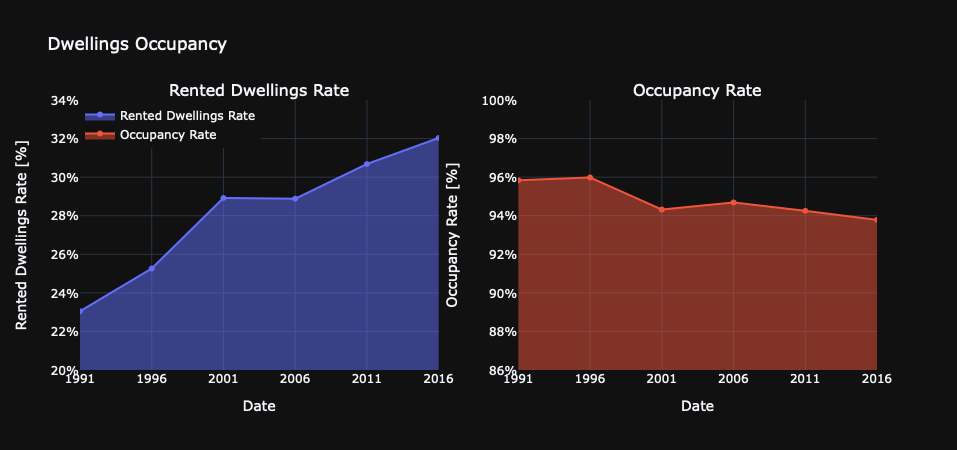

In [145]:
df = dwellings.loc['1991-04-01': '2016-04-01', ['Rented Dwellings Rate', 'Occupancy Rate']]
df.index = df.index - pd.DateOffset(months=-3)
df = df.resample('5AS').first()

ticks = ['1991', '1996', '2001', '2006', '2011', '2016']
#df.iplot(subplots=True, layout=go.Layout(
#    title='Dwellings Occupancy', 
#    height = 10,
#    yaxis=go.layout.YAxis(title="Rate", tickformat="%.0f"),
#    xaxis=go.layout.XAxis(title = "Date", tickvals=ticks, ticktext=ticks),
#    legend = go.layout.Legend(x=0, y=1)
#))

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Rented Dwellings Rate", "Occupancy Rate"))

fig.add_trace(go.Scatter(x=df.index, y=df['Rented Dwellings Rate'], 
                name="Rented Dwellings Rate", fill='tozeroy'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['Occupancy Rate'], 
                name="Occupancy Rate", fill='tozeroy'), row=1, col=2)
fig.update_xaxes(title = "Date", tickvals=ticks, ticktext=ticks, col=1, row=1)
fig.update_xaxes(title = "Date", tickvals=ticks, ticktext=ticks, col=2, row=1)
fig.update_yaxes(title="Rented Dwellings Rate [%]", tickformat="%.1f", col=1, row=1, range=[0.20, 0.34])
fig.update_yaxes(title="Occupancy Rate [%]", tickformat="%.1f", col=2, row=1, range=[0.86, 1])
fig.update_layout(
    title='Dwellings Occupancy', 
    #xaxis=go.layout.XAxis()
    legend = go.layout.Legend(x=0, y=1)
)
fig.show()

Source: Stats NZ Centuses

There is no data before 1991 and between centuces. 

Rented dwelling rate has grown significantly from 23% in 1991 to 32% in 2016. It supports the assumption that people can be forced to rent by the higher prices. 

Occupancy rate fallen insignificantly and unlikely have an high influence on the market.